In [ ]:
!pip install optuna



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.8 MB/s eta 0:00:00


[I 2025-04-19 05:14:20,901] A new study created in memory with name: no-name-b9deaaa9-f393-4402-8076-38f16a1d8b50


Dataset Shape: (1599, 12)


[I 2025-04-19 05:14:21,466] Trial 0 finished with value: 0.6208333333333333 and parameters: {'kernel': 'rbf', 'C': 21.615745496483097, 'gamma': 0.0015583851449506075}. Best is trial 0 with value: 0.6208333333333333.
[I 2025-04-19 05:14:22,032] Trial 1 finished with value: 0.6166666666666667 and parameters: {'kernel': 'sigmoid', 'C': 12.184347578760613, 'gamma': 0.0011340836503625038}. Best is trial 0 with value: 0.6208333333333333.
[I 2025-04-19 05:14:22,442] Trial 2 finished with value: 0.5958333333333333 and parameters: {'kernel': 'linear', 'C': 1.4962935921715035, 'gamma': 0.000410599663156291}. Best is trial 0 with value: 0.6208333333333333.
[I 2025-04-19 05:14:22,820] Trial 3 finished with value: 0.4354166666666667 and parameters: {'kernel': 'sigmoid', 'C': 0.4662140415357063, 'gamma': 0.0010585059847259388}. Best is trial 0 with value: 0.6208333333333333.
[I 2025-04-19 05:14:23,441] Trial 4 finished with value: 0.6020833333333333 and parameters: {'kernel': 'sigmoid', 'C': 3.37018


Results Table:
  Sample  Best Accuracy                       Best SVM Parameters
0     S1          63.54     Kernel: rbf, C: 8.811, Gamma: 0.00298
1     S2          61.25    Kernel: rbf, C: 3.0188, Gamma: 0.09086
2     S3          60.42    Kernel: rbf, C: 1.7888, Gamma: 0.05165
3     S4          66.88   Kernel: rbf, C: 49.4097, Gamma: 0.06708
4     S5          64.38    Kernel: rbf, C: 6.0602, Gamma: 0.04667
5     S6          65.42    Kernel: rbf, C: 4.6435, Gamma: 0.08755
6     S7          63.96  Kernel: poly, C: 95.3259, Gamma: 0.02517
7     S8          63.33    Kernel: rbf, C: 31.381, Gamma: 0.09886
8     S9          63.96    Kernel: rbf, C: 2.4908, Gamma: 0.05054
9    S10          65.21    Kernel: rbf, C: 12.8308, Gamma: 0.0682


<ipython-input-3-bfd50ce4de23>:73: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(best_study)


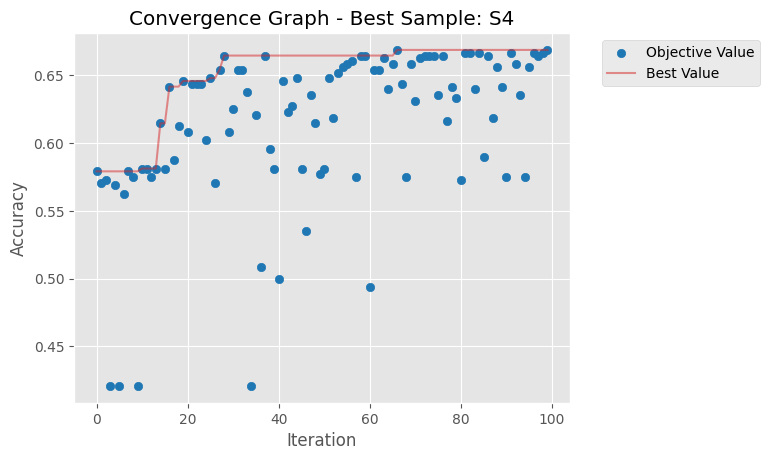

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import optuna
import matplotlib.pyplot as plt

# 1. Load UCI Wine Quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

X = df.drop("quality", axis=1)
y = df["quality"]

print("Dataset Shape:", df.shape)

# Store results
results = []
study_convergence = {}

# 2. Generate 10 different train-test splits
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    def objective(trial):
        # 3. Optimize kernel, C (nu), and gamma (epsilon for RBF)
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
        C = trial.suggest_float("C", 0.1, 100, log=True)
        gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel=kernel, C=C, gamma=gamma))
        ])

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_accuracy = study.best_value

    results.append({
        "Sample": f"S{i+1}",
        "Best Accuracy": round(best_accuracy * 100, 2),
        "Best SVM Parameters": f"Kernel: {best_params['kernel']}, C: {round(best_params['C'], 4)}, Gamma: {round(best_params['gamma'], 5)}"
    })

    # Store for convergence plot if it's the best
    study_convergence[f"S{i+1}"] = study

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nResults Table:")
print(results_df)

# Save to CSV (optional)
results_df.to_csv("svm_optimization_results.csv", index=False)

# 4. Find best sample for plotting convergence
best_sample_index = np.argmax(results_df["Best Accuracy"])
best_sample_key = f"S{best_sample_index+1}"
best_study = study_convergence[best_sample_key]

# 5. Plot Convergence Graph
fig = optuna.visualization.matplotlib.plot_optimization_history(best_study)
plt.title(f"Convergence Graph - Best Sample: {best_sample_key}")
plt.ylabel("Accuracy")
plt.xlabel("Iteration")
plt.grid(True)
plt.show()
